In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

Text(0.5, 1.0, 'dist from city center vs price')

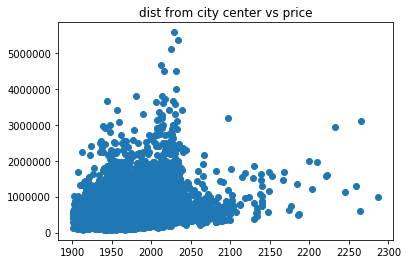

In [36]:
df = pd.read_csv('data/train_data.csv', delimiter=',')

cols = df.columns[3:-1]
numFeatures = len(cols)

# df = df.dropna(subset=cols) #drop na cells 
# df = df[df.bedrooms <= 15]
# df = df[df.sqft_lot <= 1250000]
# df = df[df.sqft_above <= 7000]
# df = df[df.sqft_basement <= 3500]
# df = df[df.sqft_lot15 <= 500000]
    

df['sqft_house'] = df['sqft_living15'] + df['sqft_above'] + df['sqft_basement']

landvalue = []
view = list(df['view'])
water = list(df['waterfront'])
house = list(df['sqft_house'])
condition = list(df['condition'])
grade = list(df['grade'])
for i in range(len(water)):
    value = (view[i] + house[i]) * (grade[i]/(condition[i] + 1))
    if water[i] == 1:
        value  = value * 2
    value = value
    landvalue.append(value)
df['landvalue'] = landvalue

scores = []
built = list(df['yr_built'])
renovated = list(df['yr_renovated'])
grade = list(df['grade'])
condition = list(df['condition'])
bathrooms = list(df['bathrooms'])
bedrooms = list(df['bedrooms'])
floors = list(df['floors'])
for i in range(len(df['yr_renovated'])):
    score = (bathrooms[i] + bedrooms[i]) ** (floors[i] - .6)
    if renovated[i] != 0:
        score += renovated[i]
    else:
        score += built[i]
    scores.append(score)
df['renovation_score'] = scores


centerpoint= (47.628591, -122.289796)  #center point of city center
dist_df = df.loc[:,['Unique_idx','lat','long','price']]
dist_df['dist_latLon'] = np.sqrt(np.square(dist_df['lat']- centerpoint[0]) + np.square(dist_df['long']-centerpoint[1]))
df['distFromSeattle'] = dist_df['dist_latLon']

df['rooms'] = df['bedrooms'] + df['bathrooms'] + df['floors']

holder = df['price']
df = df.drop(['price'], axis=1)
df['price'] = holder

#206217
cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode','distFromSeattle', 'sqft_living15', 'sqft_lot15', 'price']


# cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode','lat', 'long', 'sqft_living15', 'sqft_lot15', 'price']

# #208835
# cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'sqft_living15', 'sqft_lot15', 'price']

# #214828
# cols = ['bedrooms', 'bathrooms', 'sqft_total', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'sqft_living15', 'sqft_lot15', 'price']

# #202410
# cols = ['bedrooms', 'bathrooms', 'sqft_house', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'price']

# #194199
# cols = ['bedrooms', 'bathrooms', 'sqft_house', 'sqft_lot', 'floors', 'landvalue', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'price']

# #205393
# cols = ['sqft_house', 'zipcode', 'distFromSeattle', 'price']

df_train = df[cols]

plt.scatter(df['renovation_score'], df['price'])
plt.title('dist from city center vs price')
#dist_df['price'] = dist_df['price'].astype(float) 

In [8]:
# percent = 0.7  #choose percent to split 
# n= df_train.shape[0] #number of rows in data set before splitting
# s= math.floor(percent * n)

# y= df_train.iloc[0:s,-1]
# X = df_train.iloc[0:s,:-1]
# y_test= df_train.iloc[s:n,-1]
# X_test = df_train.iloc[s:n,:-1]


# results = []
# k = 0
# for i in range(6):
#     clf = RandomForestClassifier(max_depth=k+5, n_estimators=25)
#     clf.fit(X, y)
#     yhat = (clf.predict(X_test)).astype(int)
#     delta = yhat - y_test
#     mse = int(np.sqrt(np.mean(np.square(delta))))
#     results.append(mse)
#     k += 5

# results    =>    [268226, 246881, 239686, 203481, 197422, 204236]   

# optimal depth and number of trees = 25


# results = []
# for i in range(1,len(cols)):
#     clf = RandomForestClassifier(max_depth=25, n_estimators=25, max_features=i)
#     clf.fit(X, y)
#     yhat = (clf.predict(X_test)).astype(int)
#     delta = yhat - y_test
#     mse = int(np.sqrt(np.mean(np.square(delta))))
#     results.append(mse)

# results    =>    [214723, 210991, 202983, 209605, 198916, 195840, 199624, 195558, 199819, 185102, 197879, 202793, 204950, 203006, 210816, 200879, 214653, 194433]

# optimal feature ratio to base split on = 10/18 = 0.556

In [3]:
features = cols.copy()
df_train = df[features]
percent = 0.7  #choose percent to split 
n= df_train.shape[0] #number of rows in data set before splitting
s= math.floor(percent * n)
decision_features = int((10/18) * (len(cols) - 1))
y= df_train.iloc[0:s,-1]
y_test= df_train.iloc[s:n,-1]
features = features[:-1]
results = []
LV = False
DFS = True
SFH = False
RS = False
while len(features) > 5:
    df_train = df[features]
    decision_features = int((10/18) * (len(features)))
    X = df_train.iloc[0:s,:]
    X_test = df_train.iloc[s:n,:]
    clf = RandomForestClassifier(max_depth=25, n_estimators=25, max_features=decision_features)
    clf.fit(X, y)
    
    importance = list(clf.feature_importances_)

    yhat = (clf.predict(X_test)).astype(int)
    delta = yhat - y_test
    mse = int(np.sqrt(np.mean(np.square(delta))))
    results.append(mse)
    print('MSE:', mse, 'features:',features)
    remove = min(importance)
    removeIndex = importance.index(remove)
    removeFeature = features.pop(removeIndex)
    print("Removing:", removeFeature)
    if (LV == False) and ('waterfront' not in features) and ('view' not in features):
        features.append('landvalue')
        LV = True
    if (DFS == False) and ('long' not in features) and ('lat' not in features):
        features.append('distFromSeattle')
        DFS = True
    if (RS == False) and ('yr_renovated' not in features) and ('yr_built' not in features):
        features.append('renovation_score')
        RS = True
results

MSE: 222289 features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'sqft_living15', 'sqft_lot15']
Removing: waterfront
MSE: 212320 features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'sqft_living15', 'sqft_lot15']
Removing: yr_renovated
MSE: 215173 features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'distFromSeattle', 'sqft_living15', 'sqft_lot15']
Removing: view
MSE: 207213 features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode', 'distFromSeattle', 'sqft_living15', 'sqft_lot15', 'landvalue']
Removing: land

[222289,
 212320,
 215173,
 207213,
 222594,
 213215,
 231093,
 228802,
 221238,
 224690,
 232203,
 230437,
 224623,
 240987]

**FEATURES TO EXCLUDE (ROUGH GUIDE TO FOLLOW)**

    1) Yr_renovated

    1) View
    
    2) Floors
    
    3) Waterfront
    
    4) Condition
    
    5) Bedrooms
    
    6) Zipcode
    
    7) Yr_built

In [38]:
# 215939 - original
# cols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade','sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode','distFromSeattle', 'sqft_living15', 'sqft_lot15', 'price']

# 195801 - remove view
# cols = ['bedrooms', 'bathrooms', 'sqft_house', 'sqft_lot15', 'floors', 'waterfront', 'landvalue', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode', 'distFromSeattle', 'price']

# 198996 - remove yr_built
# cols = ['bedrooms', 'bathrooms', 'sqft_house', 'sqft_lot15', 'floors', 'landvalue', 'condition', 'grade', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 196797 - remove floors
# cols = ['bedrooms', 'bathrooms', 'sqft_house', 'sqft_lot15', 'landvalue', 'condition', 'grade', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 198684 - remove condition
# cols = ['bedrooms', 'bathrooms', 'sqft_house', 'sqft_lot15', 'landvalue', 'grade', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 196892 - remove bedrooms
# cols = ['bathrooms', 'sqft_house', 'sqft_lot15', 'landvalue', 'grade', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 210299 - remove zip, keep grade & bathrooms
# cols = ['bathrooms', 'sqft_house', 'sqft_lot15', 'landvalue', 'grade', 'renovation_score', 'distFromSeattle', 'price']

# 210358 - remove grade, keep zip & bathrooms
# cols = ['bathrooms', 'sqft_house', 'sqft_lot15', 'landvalue', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 193717 - remove bathrooms, keep zip & grade
# cols = ['sqft_house', 'sqft_lot15', 'landvalue', 'grade', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 190052 - add waterfront
cols = ['sqft_house', 'sqft_lot15', 'landvalue', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 202820 - add view
# cols = ['sqft_house', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 185928 - add condition
# cols = ['sqft_house', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 203972
# cols = ['sqft_living15', 'sqft_above', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 213927
# cols = ['sqft_living15', 'sqft_basement', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 204002
# cols = ['sqft_above', 'sqft_basement', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 191283
# cols = ['sqft_above', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 203514
# cols = ['sqft_basement', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']

# 188934
# cols = ['sqft_living', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']


df_train = df[cols]
percent = 0.7  #choose percent to split 
n= df_train.shape[0] #number of rows in data set before splitting
s= math.floor(percent * n)
decision_features = int((10/18) * (len(cols) - 1))

y= df_train.iloc[0:s,-1]
X = df_train.iloc[0:s,:-1]
y_test= df_train.iloc[s:n,-1]
X_test = df_train.iloc[s:n,:-1]


# clf = RandomForestClassifier(max_depth=25, n_estimators=25, max_features=decision_features, min_impurity_decrease=1e-6)
# clf.fit(X, y)

clf = RandomForestClassifier(ccp_alpha=1e-9,max_depth=100)
clf.fit(X, y)

print(clf.feature_importances_)

yhat = (clf.predict(X_test)).astype(int)
delta = yhat - y_test
mse = int(np.sqrt(np.mean(np.square(delta))))
mse

MemoryError: could not allocate 370933760 bytes

In [4]:
cols = ['sqft_house', 'sqft_lot15', 'landvalue','view', 'waterfront', 'grade', 'condition', 'renovation_score', 'zipcode', 'distFromSeattle', 'price']
df_train = df[cols]
decision_features = int((10/18) * (len(cols) - 1))

y= df_train.iloc[:,-1]
X = df_train.iloc[:,:-1]

clf = RandomForestClassifier(max_depth=25, n_estimators=25, max_features=decision_features)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [5]:
df = pd.read_csv('data/val_data.csv', delimiter=',')

scores = []
built = list(df['yr_built'])
renovated = list(df['yr_renovated'])
grade = list(df['grade'])
condition = list(df['condition'])
for i in range(len(df['yr_renovated'])):
    if renovated[i] != 0:
        score = renovated[i]
    else:
        score = built[i]
    scores.append((score * (grade[i] + 1) * (condition[i] + 1)) / built[i])
df['renovation_score'] = scores

landvalue = []
view = list(df['view'])
water = list(df['waterfront'])
living = list(df['sqft_living15'])
lot = list(df['sqft_lot15'])
attic = list(df['sqft_above'])
basement = list(df['sqft_basement'])
for i in range(len(water)):
    value = view[i] + 1
    if water[i] == 1:
        value  = value ** value
    landvalue.append(value)
df['landvalue'] = landvalue

df['sqft_house'] = df['sqft_living15'] + df['sqft_above'] + df['sqft_basement']

centerpoint= (47.628591, -122.289796)  #center point of city center
dist_df = df.loc[:,['Unique_idx','lat','long']]
dist_df['dist_latLon'] = np.sqrt(np.square(dist_df['lat']- centerpoint[0]) + np.square(dist_df['long']-centerpoint[1]))
df['distFromSeattle'] = dist_df['dist_latLon']

# holder = df['price']
# df = df.drop(['price'], axis=1)
# df['price'] = holder

df.head()

,Unique_idx,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,renovation_score,landvalue,sqft_house,distFromSeattle
0,15544,1310430130,20141009T000000,4,2.75,2790,6600,2.0,0,0,...,0,98058,47.4362,-122.109,2900,6752,40.0,1,5690,0.264010
1,17454,2540830020,20150401T000000,3,2.25,1630,6449,1.0,0,0,...,0,98011,47.7275,-122.232,1620,7429,32.0,1,3250,0.114557
2,21548,8835770330,20140819T000000,2,1.50,2370,184231,2.0,0,0,...,0,98045,47.4543,-121.778,3860,151081,48.0,1,6230,0.540659
3,3427,7732400490,20141105T000000,4,2.50,2270,7665,2.0,0,0,...,0,98052,47.6612,-122.148,2450,8706,40.0,1,4720,0.145497
4,8809,2800031,20150401T000000,3,1.00,1430,7599,1.5,0,0,...,0,98168,47.4783,-122.265,1290,10320,35.0,1,2720,0.152323


In [7]:
X = df[cols[:-1]]
yhat = (clf.predict(X)).astype(int)

results_df = pd.DataFrame(columns = ['Unique_idx', 'price']) 
results_df['Unique_idx'] = df['Unique_idx']
results_df['price'] = yhat

results_df = results_df.set_index('Unique_idx')
results_df

,price
Unique_idx,
15544,764000
17454,255000
21548,920000
3427,819900
8809,300000
3294,650000
275,354000
8736,695000
6161,750000


In [8]:
results_df.to_csv('results.csv', sep=',', encoding='utf-8')